In [2]:
from __future__ import division
import numpy as np
import glob
import matplotlib.pyplot as plt
import cPickle as pickle
import scipy.linalg as sl
import scipy.special as ss

import enterprise
from enterprise.signals import parameter
from enterprise.pulsar import Pulsar
from enterprise.signals import selections
from enterprise.signals import signal_base
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise.signals import utils

from tests.enterprise_test_data import datadir

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from corner import corner, quantile

% matplotlib inline
%config InlineBackend.figure_format = 'retina'

Do not have mpi4py package.
Do not have acor package


# Introducing `enterprise`

<img src="img/enterprise.jpg" max-width="100%"/>

**by: Justin Ellis$^{1,2}$, Michele Vallisneri$^2$, Paul Baker$^1$, Steve Taylor$^2$**

$^1$  Center for Gravitational Waves and Cosmology, West Virginia University

$^2$ Jet Propulsion Laboratory, California Institute of Technology

## What is `enterprise` ?

* `enterprise` is an **E**nhanced **N**umerical **T**oolbox **E**nabling a **R**obust **P**ulsa**R** **I**nference **S**uit**E** (complaints about this backronym are to be directed to Steve Taylor)

* Setting aside this backronym, `enterprise` really is a toolbox, **not** a set of *black box* functions and scripts!

* Extremely well tested (91% coverage!), well [documented](https://enterprise.readthedocs.io/), and easy to use and to modify.

* Code development is done in a collaborative "fork and pull request" workflow.
    * PRs must pass all unit tests including syntactic `pep8` tests.
    * PRs must provide tests for new functionality (i.e. test coverage cannot drop).
    * PRs must be reviewed by code maintainers.

## Why do we need `enterprise`?

* Have you seen `PAL2`/`NX01`/`piccard` code?

* Need ability to add more complicated and customized signals to PTA models. 

* Need better tested and better documented code base.

* Need more user friendly and intuitive API, along with simple channels for code development.

* We want `enterprise` to be the base for all of your future pulsar timing residual modeling needs.

## `enterprise` code architecture
<img src="img/signal_collection.jpg" max-width="100%"/>

* The data (residuals) are modeled as the sum of `Signal` components which have their own `Parameter`s.
* The sum of all `Signal` components is a `SignalCollection`.

## `enterprise` code architecture
<img src="img/pta.jpg" max-width="100%"/>

* Each pulsar's model is a `SignalCollection` that are combined to form a `PTA`.
* Common `Signal`s are shared across pulsars 
* `Likelihood`s act on `PTA`s. 

## Anatomy of an `enterprise` `Signal`
* $\delta\tau = \sum_{i} X(\phi_{\rm basis})_{(i)}w_{(i)} + s(\phi_{\rm det}) + n(\phi_{\rm white})$
* $w_{(i)} | K_{(i)} = \mathrm{Normal}(0, K(\phi_{\rm gp})_{(i)})$


```python
class Signal(object):
    """Base class for Signal objects."""

    def get_ndiag(self, params):
        """Returns the diagonal of the white noise vector `N`.
        This method also supports block diagaonal sparse matrices.
        """
        return None

    def get_delay(self, params):
        """Returns the waveform of a deterministic signal."""
        return 0

    def get_basis(self, params=None):
        """Returns the basis array of shape N_toa x N_basis."""
        return None

    def get_phi(self, params):
        """Returns a diagonal or full rank covaraince matrix 
        of the basis amplitudes."""
        return None

    def get_phiinv(self, params):
        """Returns inverse of the covaraince of basis amplitudes."""
        return None
```


<img src="img/engage.jpg" max-width="100%"/>

## Standard Noise Analysis

In [3]:
psr = Pulsar(datadir + '/B1855+09_NANOGrav_9yv1.gls.par', datadir + '/B1855+09_NANOGrav_9yv1.tim')

* Set up Parameters

In [15]:
# define white noise parameters
efac = parameter.Uniform(0.1, 10)
log10_equad = parameter.Uniform(-10, -5)
log10_ecorr = parameter.Uniform(-10, -5)

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

* Construct Signal and initialize PTA (of one)

In [184]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

# define white noise signals (selection tells it to split based on backend)
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=log10_equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=log10_ecorr, selection=selection)

# define powerlaw PSD and red noise signal
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(pl, components=30)

# linear timing model
tm = gp_signals.TimingModel()

# total signal (this is some high tech shit right here!)
s = ef + eq  + ec + tm + rn 

# setup PTA
pta = signal_base.PTA([s(psr)])

* Check parameterization with:

In [18]:
print pta.params

["B1855+09_430_ASP_efac":Uniform(0.1,10), "B1855+09_430_ASP_log10_ecorr":Uniform(-10,-5), "B1855+09_430_ASP_log10_equad":Uniform(-10,-5), "B1855+09_430_PUPPI_efac":Uniform(0.1,10), "B1855+09_430_PUPPI_log10_ecorr":Uniform(-10,-5), "B1855+09_430_PUPPI_log10_equad":Uniform(-10,-5), "B1855+09_L-wide_ASP_efac":Uniform(0.1,10), "B1855+09_L-wide_ASP_log10_ecorr":Uniform(-10,-5), "B1855+09_L-wide_ASP_log10_equad":Uniform(-10,-5), "B1855+09_L-wide_PUPPI_efac":Uniform(0.1,10), "B1855+09_L-wide_PUPPI_log10_ecorr":Uniform(-10,-5), "B1855+09_L-wide_PUPPI_log10_equad":Uniform(-10,-5), "B1855+09_gamma":Uniform(0,7), "B1855+09_log10_A":Uniform(-20,-11)]


* Access to likelihood and prior function with:

In [19]:
# random parameters for testing
xs = {p.name: p.sample() for p in pta.params}

# likelihood
print pta.get_lnlikelihood(xs)

# prior
print pta.get_lnprior(xs)

-6886.41549079
-26.1887770544


* These likelihood and prior functions can then be fed to the sampler of your choice!

## 11-year Stochastic GWB upper limit with ephemeris modeling

In [20]:
with open("/Users/jaellis/Packages/enterprise/tests/nano11_DE436.pkl", "rb") as f:
    psrs = pickle.load(f) 

In [29]:
with open("/Users/jaellis/Packages/enterprise/tests/nano11_setpars.pkl", "rb") as f:
    setpars = pickle.load(f)

* Setup Parameters

In [182]:
# white noise parameters
# set them to constant here and we will input the noise values 
# after the model is initialized
efac = parameter.Constant()
equad = parameter.Constant()
ecorr = parameter.Constant()

# red noise parameters
# LinearExp prior places uniform prior on A while sampling in log10_A
log10_A = parameter.LinearExp(-20, -11)
gamma = parameter.Uniform(0, 7)

# common red noise
# naming signals here tells enterprise that these parameters
# are shared across pulsars
log10_Agw = parameter.LinearExp(-18, -11)('log10_Agw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

* Set up Signals

In [ ]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

# define white noise signals
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# get overall time span
tmin = np.min([p.toas.min() for p in psrs])
tmax = np.min([p.toas.max() for p in psrs])
Tspan = tmax - tmin

# define powerlaw PSD and red noise signal
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(pl, components=30, Tspan=Tspan)

# GWB
cpl = utils.powerlaw(log10_A=log10_Agw, gamma=gamma_gw)
orf = utils.hd_orf()
crn = gp_signals.FourierBasisCommonGP(cpl, orf, components=30, Tspan=Tspan)

# linear timing model
tm = gp_signals.TimingModel()

## Physical ephemeris model
eph = deterministic_signals.PhysicalEphemerisSignal(use_epoch_toas=True)

* Create total signal and intialize PTA

In [ ]:
# total signal 
s = ef + eq + ec + rn + crn + tm + eph

# setup PTA
pta = signal_base.PTA([s(p) for p in psrs])

# set fixed white noise parameters
pta.set_default_params(setpars)

In [180]:
print pta.params

["B1855+09_gamma":Uniform(0,7), "B1855+09_log10_A":Uniform(-20,-11), "B1937+21_gamma":Uniform(0,7), "B1937+21_log10_A":Uniform(-20,-11), "B1953+29_gamma":Uniform(0,7), "B1953+29_log10_A":Uniform(-20,-11), "J0023+0923_gamma":Uniform(0,7), "J0023+0923_log10_A":Uniform(-20,-11), "J0030+0451_gamma":Uniform(0,7), "J0030+0451_log10_A":Uniform(-20,-11), "J0340+4130_gamma":Uniform(0,7), "J0340+4130_log10_A":Uniform(-20,-11), "J0613-0200_gamma":Uniform(0,7), "J0613-0200_log10_A":Uniform(-20,-11), "J0645+5158_gamma":Uniform(0,7), "J0645+5158_log10_A":Uniform(-20,-11), "J1012+5307_gamma":Uniform(0,7), "J1012+5307_log10_A":Uniform(-20,-11), "J1024-0719_gamma":Uniform(0,7), "J1024-0719_log10_A":Uniform(-20,-11), "J1455-3330_gamma":Uniform(0,7), "J1455-3330_log10_A":Uniform(-20,-11), "J1600-3053_gamma":Uniform(0,7), "J1600-3053_log10_A":Uniform(-20,-11), "J1614-2230_gamma":Uniform(0,7), "J1614-2230_log10_A":Uniform(-20,-11), "J1640+2224_gamma":Uniform(0,7), "J1640+2224_log10_A":Uniform(-20,-11), "J1

## That's great and all, but what if I want to make a new signal?

* There are 3 types of built in generic signals for different signal types
    * `gp_signals.BasisGP` for Gaussian Process signals that have a set of *basis functions* and a *kernel*.
    * `white_signals.WhiteNoise` for white noise signals with a specific *variance*.
    * `deterministic_signals.Deterministic` for determinisic signals that return a *delay waveform*.

## Generic Gaussian Process Signal

* Suppose we want to do Ridge regression on the linear timing model (Gaussian prior on coefficient)

In [45]:
@signal_base.function
def scaled_tm_basis(Mmat):
    """Returns mean and variance scaled timing model
    design matrix and weights to be used in prior 
    function."""
    
    mn = Mmat.mean(axis=0)
    sd = Mmat.std(axis=0)
    
    ret = Mmat.copy()
    ret[:, 1:] -= mn[1:]
    ret[:, 1:] /= sd[None, 1:]
    
    return ret, np.ones_like(mn)

@signal_base.function
def ridge_prior(weights, log10_variance=-14):
    """Return gaussian prior with variance parameter."""
    return weights * 10**(log10_variance)

* Basis function must return an `ntoa` x `nbasis` array and an `nbasis` vector of weights.
* Prior function must return either an `nbasis` array (diagonal of covariance matrix) or the full `nbasis` x `nbasis` covariance matrix.

* Can be added to model via:

In [59]:
log10_variance = parameter.Uniform(-20, -10)
basis = scaled_tm_basis()
prior = ridge_prior(log10_variance=log10_variance)
ridge = gp_signals.BasisGP(prior, basis, name='ridge')

In [ ]:
# can intialize this single signal to check
ridge_signal = ridge(psrs[0])
print(ridge_signal.params)
params = {p.name: p.sample() for p in ridge_signal.params}

# print basis
print(ridge_signal.get_basis(params))

# print diagonal of prior covariance matrix
print(ridge_signal.get_phi(params))

## Generic White Noise Signal

* Suppose we want to add a DMEQUAD signal:

In [48]:
# define DM EQUAD variance function
@signal_base.function
def dmequad_ndiag(freqs, log10_dmequad=-8):
    """Reads in radio frequencies and DMEQUAD value and outputs variance."""
    return np.ones_like(freqs) * (1400/freqs)**4 * 10**(2*log10_dmequad)

* Variance function must return the variance in seconds$^{2}$.
* Because this is an `enterprise` `Function` it reads `freqs` directly from the `Pulsar` object.

* can be added to signal via:

In [52]:
log10_dmequad = parameter.Uniform(-10, -5)
dmvariance = dmequad_ndiag(log10_dmequad=log10_equad)
dmeq = white_signals.WhiteNoise(dmvariance)

In [58]:
# can intialize this single signal to check
dmequad_signal = dmeq(psrs[0])
print(dmequad_signal.params)
params = {p.name: p.sample() for p in dmequad_signal.params}

# print variance
print(dmequad_signal.get_ndiag(params))

["B1855+09_log10_dmequad":Uniform(-10,-5)]
[  1.41104773e-20   1.51135064e-20   1.36401696e-20 ...,   1.43430536e-18
   1.47540039e-18   1.45466507e-18]


## Generic Deterministic Signal

* Suppose we want to add a wavelet signal.

In [72]:
@signal_base.function
def wavelet(toas, log10_A=-7, log10_Q=2, t0=55000, log10_f0=-7.5, phi0=0):
    # convert units
    A = 10**log10_A
    Q = 10**log10_Q * const.day
    t0 *= const.day
    f0 = 10**log10_f0
    wv = A * np.cos(2*np.pi*f0*(toas-t0)+phi0) * np.exp(-(toas-t0)**2/2/Q**2)
    return wv

* Waveform function must return delay waveform in seconds

* Can be added to signal via:

In [78]:
log10_A = parameter.Uniform(-10, -5)
log10_Q = parameter.Uniform(0, 3)
t0 = parameter.Uniform(53000, 58000)
log10_f0 = parameter.Uniform(-9, -6)
phi0 = parameter.Uniform(0, 2*np.pi)
wf = wavelet(log10_A=log10_A, log10_Q=log10_Q, t0=t0, 
             log10_f0=log10_f0, phi0=phi0)
wvlt = deterministic_signals.Deterministic(wf)

["B1855+09_t0":Uniform(53000,58000), "B1855+09_log10_A":Uniform(-10,-5), "B1855+09_phi0":Uniform(0,6.28318530718), "B1855+09_log10_f0":Uniform(-9,-6), "B1855+09_log10_Q":Uniform(0,3)]


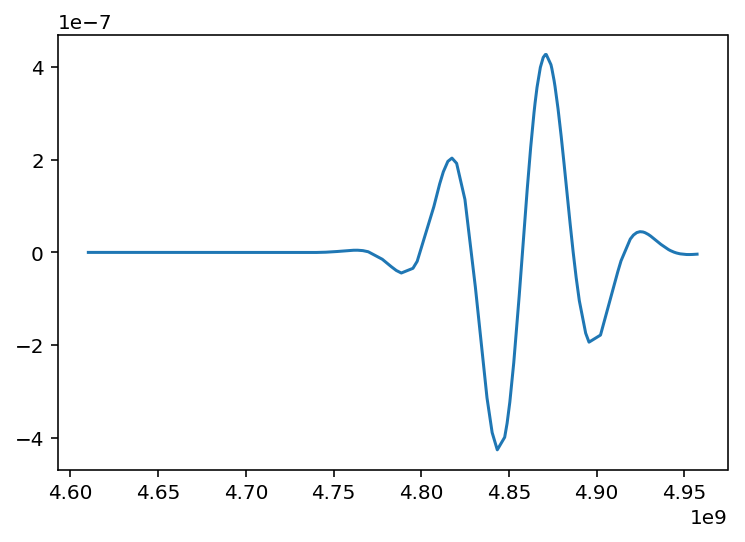

In [89]:
# initialize signal to check
wavelet_signal = wvlt(psrs[0])
print(wavelet_signal.params)

params = {p.name: p.sample() for p in wavelet_signal.params}

wave = wavelet_signal.get_delay(params)
plt.plot(psrs[0].toas, wave)

## Custom Signals

* It may be the case that your signal doesn't fit nicely into the above categories
* Maybe you need to do a lot of work to set up the signal (reading in auxiliary files, interpolations, etc.)
* In that case you may have to do a bit more work, but not too much :)
* You can subclass one of the existing generic signal types and modify the methods or you can subclass the base `Signal` class if your signal is very different.

## Fourier Basis example

* This `FourierBasisGP` class is actually part of `enterprise` but it works for an example of how to sublcass an existing `Signal`.
* Remember we use *Class Factories* not just classes. See the [documentation](https://enterprise.readthedocs.io/en/latest/data.html#class-factories) on this for more details.

In [91]:
def FourierBasisGP(spectrum, components=20,
                   selection=selections.Selection(selections.no_selection),
                   Tspan=None):
    """Convenience function to return a BasisGP class with a
    fourier basis."""

    # use fourier basis and use BasisGP
    basis = utils.createfourierdesignmatrix_red(nmodes=components, Tspan=Tspan)
    BaseClass = BasisGP(spectrum, basis, selection=selection)

    class FourierBasisGP(BaseClass):
        signal_type = 'basis'
        signal_name = 'red noise'

    return FourierBasisGP

* In this example we simply define the Fourier Basis inside of the factory and don't overwrite any methods.

## Subclassing `Deterministic` example

* Say we want to use the wavelet signal defined above, but we don't want to have to evaluate it for all of the per-channel TOAs
* We would rather use the epochs to evaluate the waveform and then interpolate back on to the TOAs in the end
* We can do that as follows

In [177]:
def WaveletSignal(log10_A, log10_Q, t0, log10_f0, phi0, use_epoch_toas=True):
    """Wavelet signal with option to use epoch TOAs"""

    # setup wavelet signal and use Deterministic
    wf = wavelet(log10_A=log10_A, log10_Q=log10_Q, t0=t0, 
                 log10_f0=log10_f0, phi0=phi0)
    BaseClass = deterministic_signals.Deterministic(wf, name='wavelet')

    class WaveletSignal(BaseClass):

        def __init__(self, psr):

            super(WaveletSignal, self).__init__(psr)

            if use_epoch_toas:
                # get quantization matrix and calculate daily average TOAs
                U, _ = utils.create_quantization_matrix(psr.toas, nmin=1)
                self.uinds = utils.quant2ind(U)
                avetoas = np.array([psr.toas[sc].mean() for sc in self.uinds])
                
                # replace kwarg in waveform with avetoas instead of toas
                self._wf[''].add_kwarg(toas=avetoas)

        @signal_base.cache_call('delay_params')
        def get_delay(self, params):
            delay = self._wf[''](params=params)
            if use_epoch_toas:
                for slc, val in zip(self.uinds, delay):
                    self._delay[slc] = val
                return self._delay
            else:
                return delay

    return WaveletSignal

* This is a bit advanced but gives you an idea of how you can make completely custom signals.

In [173]:
# check to make sure they give the same answer
log10_A = parameter.Uniform(-10, -5)
log10_Q = parameter.Uniform(0, 3)
t0 = parameter.Uniform(53000, 58000)
log10_f0 = parameter.Uniform(-9, -6)
phi0 = parameter.Uniform(0, 2*np.pi)
wave = WaveletSignal(log10_A=log10_A, log10_Q=log10_Q, t0=t0, 
                     log10_f0=log10_f0, phi0=phi0)
wave2 = WaveletSignal(log10_A=log10_A, log10_Q=log10_Q, t0=t0, 
                     log10_f0=log10_f0, phi0=phi0, use_epoch_toas=False)

In [174]:
wv1 = wave(psrs[0])
wv2 = wave2(psrs[0])

params = {p.name: p.sample() for p in wv1.params}
d1 = wv1.get_delay(params=params)
d2 = wv2.get_delay(params=params)

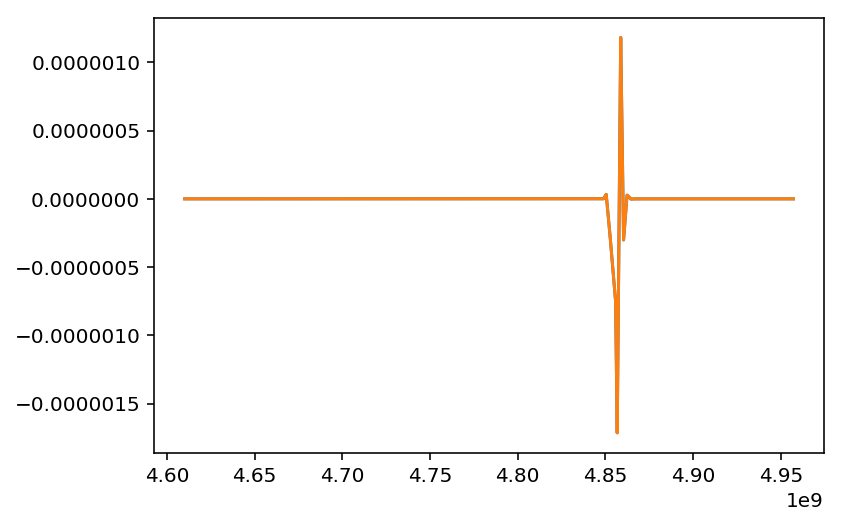

In [175]:
plt.plot(psrs[0].toas, d1)
plt.plot(psrs[0].toas, d2)

## Non-stationary `Signal`s via `Selection`s

* You might have noticed the `selection` arguments above.
* This allows us to split up the signal into different segments (per backend for example) via a user defined `Selection` function
* All base `BasisGP`, `WhiteNoise`, and `Deterministic` `Signals` support selection.
* Say we want to model the first half of the data independently from the rest for a certain signal, we can define the following:

In [178]:
def cut_half(toas):
    """Selection function to split by data segment"""
    midpoint = (toas.max() + toas.min()) / 2
    return dict(zip(['t1', 't2'], [toas <= midpoint, toas > midpoint]))

* Use `selection=selections.Selection(cut_half)` as a keyword argument in the signal and thats it!

## And now...

<iframe width="560" height="315" src="https://www.youtube.com/embed/-ZxHAZChcYU" frameborder="0" allowfullscreen></iframe>